<a href="https://colab.research.google.com/github/kevinhoffmanglyde/oxfordgenaigroup2/blob/main/Group2EndtoEnd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Section Overview:#
This section is a model comparision for selection of the models.
To use the selected model in the project for the business, we need to be able to feed in a full dataset, retrain the model based on the new data, and create predictions based on the fresh data and newly trained model.
This section separates the Training and Test data for checking accuracy and loss in order to select the better model for the job.
###2024-05-06 - there are some issues with the presentation of charts for comparison.  Also, Prophet is working but requires different names for comparison.  The predictions across the board look like a near perfect match to the Test data.  This is unexpected.  The visualisations are currently wholey unsatisfactory.###


#Mount the Google Drive

In [176]:
import pandas as pd
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#Authenticate

In [177]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


#Get the data

In [209]:
df = pd.read_csv('gdrive/MyDrive/synt_data.csv')

#Check the data is there

In [210]:
df.head()

,Store ID,Country,Product ID,Product Category,Units Sold,Date of Sale,GDP Growth Rate,Inflation Rate,Price Sold
0,5954,Spain,16174,Mens,58,2023-07-03,0.01,2.87,94.37
1,9190,Austria,54058,Mens,88,2023-12-04,1.55,0.75,73.63
2,4997,Italy,16301,Mens,69,2023-11-28,1.32,1.12,22.10
3,9188,Austria,83886,Mens,64,2024-03-21,1.24,0.86,32.87
4,3675,France,68267,Mens,12,2024-03-24,1.28,2.62,80.72


##Now examine the data
The biggest worry is that once we get to the testing of the model, using the synthetic data, we may be trying to map the model based on the training data to data that is completely random.
Since we have data for May 2023 to May 2024 I selected a splitting date of Feb 1st 2024 so we have nearly a 75 to 25% split and are predicting for the latter quarter of the timeframe.
I did not split on the random 80/20 split because we would be including values for the prediction timeframe in the Training set, if I did.

In [211]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import datetime
datetosplit = '2024-02-01'
reference_date = datetime.date(1970, 1, 1)
# train_test_split is used to easily divide data into training and testing sets.
from sklearn.model_selection import train_test_split
# LinearRegression is the model we'll be using from scikit-learn.
from sklearn.linear_model import LinearRegression
# mean_absolute_error and mean_squared_error are metrics to evaluate our model.
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# matplotlib.pyplot is used for plotting graphs.
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

In [212]:
df = df.sort_values(["Date of Sale"], ascending = (True)) # order the data by year, month, day in ascending order.
df.head() # check the data again by viewing the first 5 rows

,Store ID,Country,Product ID,Product Category,Units Sold,Date of Sale,GDP Growth Rate,Inflation Rate,Price Sold
199627,2118,Germany,20385,Womens,32,2023-05-04,1.89,2.46,63.77
154482,10059,Denmark,16106,Womens,79,2023-05-04,1.16,0.48,22.50
29229,2881,Germany,88964,Womens,84,2023-05-04,0.15,1.33,24.19
154639,7176,Belgium,93521,Mens,78,2023-05-04,2.43,2.48,37.30
154901,6572,Netherlands,12538,Womens,98,2023-05-04,0.72,0.23,61.17


In [213]:
df.describe()

,Store ID,Product ID,Units Sold,GDP Growth Rate,Inflation Rate,Price Sold
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,5987.140990,55076.436663,50.572453,1.448650,1.449116,54.996854
std,2889.554299,25986.196626,28.857025,0.855469,0.855604,25.982285
min,1000.000000,10000.000000,1.000000,0.000000,0.000000,10.000000
25%,3476.000000,32605.000000,26.000000,0.710000,0.710000,32.480000
50%,5985.000000,55124.000000,51.000000,1.430000,1.430000,54.950000
75%,8488.000000,77569.250000,76.000000,2.160000,2.170000,77.450000
max,10999.000000,99999.000000,100.000000,3.000000,3.000000,100.000000


In [183]:
df.isnull().sum()

Store ID            0
Country             0
Product ID          0
Product Category    0
Units Sold          0
Date of Sale        0
GDP Growth Rate     0
Inflation Rate      0
Price Sold          0
dtype: int64

Looks like no Nulls, which is expected for our synthetic data.

In [214]:
df['Units Sold'].isna().sum()

0

In [216]:
#clean up any nulls that might come through in real data
df = df.dropna(subset=['Store ID', 'Product ID', 'Units Sold', 'Date of Sale'])

##Check out the distribution of the data

In [217]:
unique_store = df['Store ID'].nunique()
unique_product = df['Product ID'].nunique()
unique_product_cat = df['Product Category'].nunique()
unique_country = df['Country'].nunique()


print("Distinct Stores:", unique_store)
print("Distinct Products:", unique_product)
print("Distinct Product Categories:", unique_product_cat)
print("Distinct Countries:", unique_country)

Distinct Stores: 10000
Distinct Products: 86734
Distinct Product Categories: 2
Distinct Countries: 10


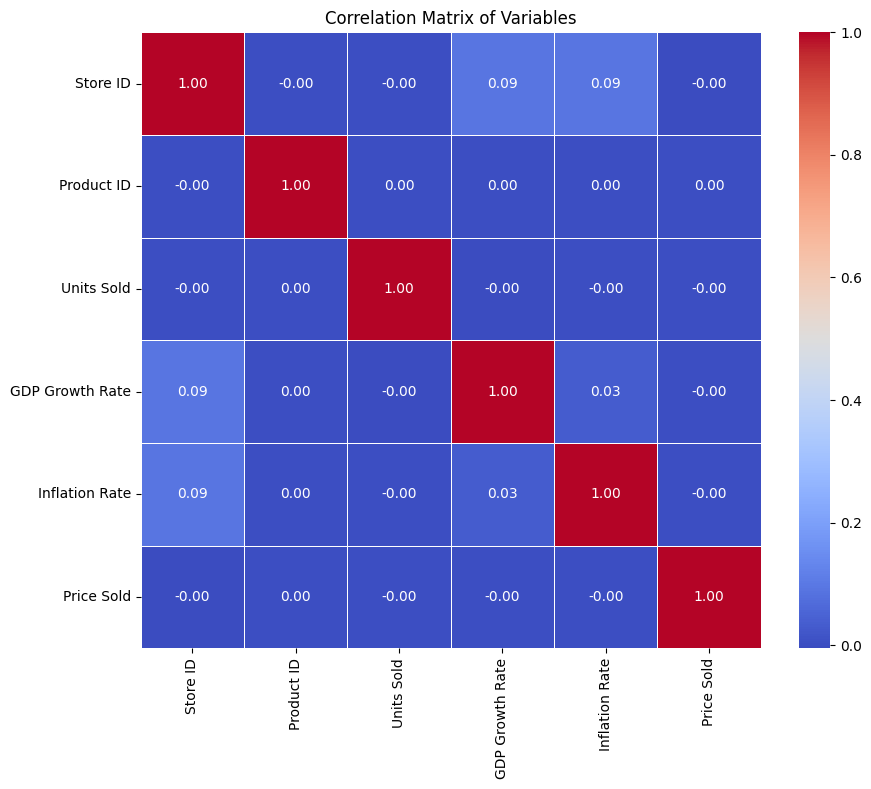

In [218]:
# Calculating the correlation matrix
correlation_matrix = df.corr(numeric_only=True)
#numeric_only is a new variable for the correlation matrix.
#If we want to include Country, we would have to include one-hot-encoding on Country because it is a string and will not fit in a correlation matrix.
# Initializes a new figure for plotting with a specified size to ensure the heatmap is large enough to read.
plt.figure(figsize=(10, 8))

# Creates a heatmap to visualize the correlation matrix.
# - annot=True displays the correlation coefficient values inside the squares.
# - cmap='coolwarm' chooses a color map that visually represents positive (warm) and negative (cool) correlations.
# - fmt=".2f" formats the annotation strings to display only two decimal places.
# - linewidths=.5 adds lines between squares to separate them visually.
sn.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Sets the title of the heatmap for clarity.
plt.title('Correlation Matrix of Variables')

# Displays the plot. Without this, the figure would not be shown in a notebook.
plt.show()

In [219]:
min_sale_date = df['Date of Sale'].min()
max_sale_date = df['Date of Sale'].max()

print("Minimum date:", min_sale_date)
print("Maximum date:", max_sale_date)

Minimum date: 2023-05-04
Maximum date: 2024-05-03


#Date issues##
Since we are trying to predict future demand, this suggests that when we divide the Training and Test data, we need to do this on a date basis.  Including dates in the training set that should appear in the test set is not desired.  When using this on real data in production, the future dates will all be empty.

So, selecting out test and train data set should probably be on dates rather than simply a percentage.  The suggestion here is that we train 9 months and test against 3 months.

Once the data split is completed, I had to drop the Date of Sale feature because it would not process as a number.  The componensts of the date can be reconstituted for charts at a later point.
The below includes one-hot encoding for the Product Category and Country.

In [243]:
df['Date of Sale'] = pd.to_datetime(df['Date of Sale'])
print(df['Date of Sale'].head(10))
#df['Units Sold'] = df['Units Sold'].astype(int)
print('Actuals:', df['Units Sold'].head(10))

# find the rows that contain non-integer values
print(df['Units Sold'].head(10))

199627   2023-05-04
154482   2023-05-04
29229    2023-05-04
154639   2023-05-04
154901   2023-05-04
29143    2023-05-04
14138    2023-05-04
155240   2023-05-04
155247   2023-05-04
155836   2023-05-04
Name: Date of Sale, dtype: datetime64[ns]
Actuals: 199627    32
154482    79
29229     84
154639    78
154901    98
29143     76
14138     71
155240    53
155247     8
155836    99
Name: Units Sold, dtype: int64
199627    32
154482    79
29229     84
154639    78
154901    98
29143     76
14138     71
155240    53
155247     8
155836    99
Name: Units Sold, dtype: int64


In [135]:
df['Date of Sale'] = pd.to_datetime(df['Date of Sale'])
#df['DOS'] = (df['Date of Sale'] - reference_date).days
# Selecting the features for the model. These are the independent variables.
#X = df[['Store ID', 'Product Category', 'Date of Sale', 	'GDP Growth Rate',	'Inflation Rate',	'Price Sold']]


X = df[['Store ID', 'Date of Sale', 'GDP Growth Rate', 'Inflation Rate', 'Price Sold']]
X = pd.get_dummies(df, columns=['Product Category'])
X = pd.get_dummies(X, columns=['Country'])
X['Year'] = df['Date of Sale'].dt.year
X['Month'] = df['Date of Sale'].dt.month
X['Day'] = df['Date of Sale'].dt.day
X['Weekday'] = df['Date of Sale'].dt.weekday  # Monday=0, Sunday=6

y = df['Units Sold']
split_date = pd.to_datetime(datetosplit)
# Data before the split date
X_Train = X[X['Date of Sale'] < split_date]
X_Test = X[X['Date of Sale'] >= split_date]
Y_Train = y[df['Date of Sale'] < split_date]
Y_Test = y[df['Date of Sale'] >= split_date]
X_Train = X_Train.drop(columns=['Date of Sale'])

X_Test = X_Test.drop(columns=['Date of Sale'])

print("Data before the split date:")
print(X_Train)

print("Data on or after the split date:")
print(X_Test)

print("Data before the split date:")
print(Y_Train)

print("Data on or after the split date:")
print(Y_Test)

Data before the split date:
        Store ID  Product ID  Units Sold  GDP Growth Rate  Inflation Rate  \
199627      2118       20385          32             1.89            2.46   
154482     10059       16106          79             1.16            0.48   
29229       2881       88964          84             0.15            1.33   
154639      7176       93521          78             2.43            2.48   
154901      6572       12538          98             0.72            0.23   
...          ...         ...         ...              ...             ...   
97393       7770       98383          28             1.22            0.13   
287076      8664       36655           8             1.86            3.00   
255067      5986       34341          16             2.68            1.38   
35739       1224       64658          88             0.93            0.91   
12015       7291       80938          91             1.42            1.05   

        Price Sold  Product Category_Mens  Prod

#Now we look at a Linear Regression model

In [137]:
# Creating an instance of the LinearRegression model.
modelLR = LinearRegression()

# Fitting the model to the training data. This is where the model learns the relationship between features and target.
modelLR.fit(X_Train, Y_Train)


LinearRegression()

In [138]:
# Use the trained model to make predictions on the testing set.
predictionsLR = modelLR.predict(X_Test)

# Evaluating the model's performance by comparing actual values (y_test) vs predicted values (predictions).
# MAE is the mean absolute error, MSE is the mean squared error, and RMSE is the square root of MSE.
print('MAE:', mean_absolute_error(Y_Test, predictionsLR))
print('MSE:', mean_squared_error(Y_Test, predictionsLR))
print('RMSE:', np.sqrt(mean_squared_error(Y_Test, predictionsLR)))

MAE: 2.0702565723249515e-14
MSE: 6.8978802856461355e-28
RMSE: 2.6263815955885268e-14


In [139]:
X.describe()

,Store ID,Product ID,Units Sold,Date of Sale,GDP Growth Rate,Inflation Rate,Price Sold,Year,Month,Day,Weekday
count,300000.000000,300000.000000,300000.000000,300000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,5987.140990,55076.436663,50.572453,2023-11-02 06:57:12.384000,1.448650,1.449116,54.996854,2023.337720,6.520263,15.741077,2.999157
min,1000.000000,10000.000000,1.000000,2023-05-04 00:00:00,0.000000,0.000000,10.000000,2023.000000,1.000000,1.000000,0.000000
25%,3476.000000,32605.000000,26.000000,2023-08-03 00:00:00,0.710000,0.710000,32.480000,2023.000000,4.000000,8.000000,1.000000
50%,5985.000000,55124.000000,51.000000,2023-11-02 00:00:00,1.430000,1.430000,54.950000,2023.000000,7.000000,16.000000,3.000000
75%,8488.000000,77569.250000,76.000000,2024-02-02 00:00:00,2.160000,2.170000,77.450000,2024.000000,10.000000,23.000000,5.000000
max,10999.000000,99999.000000,100.000000,2024-05-03 00:00:00,3.000000,3.000000,100.000000,2024.000000,12.000000,31.000000,6.000000
std,2889.554299,25986.196626,28.857025,NaN,0.855469,0.855604,25.982285,0.472933,3.447385,8.809773,1.996394


#Charts#
I'm fairly sure I made an error somewhwere in here because it seems that the predicted values and actual values are the same according to the chart.  According the the MAE this is not the case.
I printed out the values for prediction and test, and the results were a match for what values I could see.

210752   2024-02-01
35957    2024-02-01
131439   2024-02-01
91245    2024-02-01
285134   2024-02-01
192537   2024-02-01
219451   2024-02-01
217150   2024-02-01
292747   2024-02-01
274888   2024-02-01
Name: Date of Sale, dtype: datetime64[ns]
Predictions: [ 9. 55. 60. ... 12. 31. 45.]
Actuals: 210752     9
35957     55
131439    60
91245     64
285134    14
192537    12
219451    16
217150    14
292747    25
274888    27
Name: Units Sold, dtype: int64


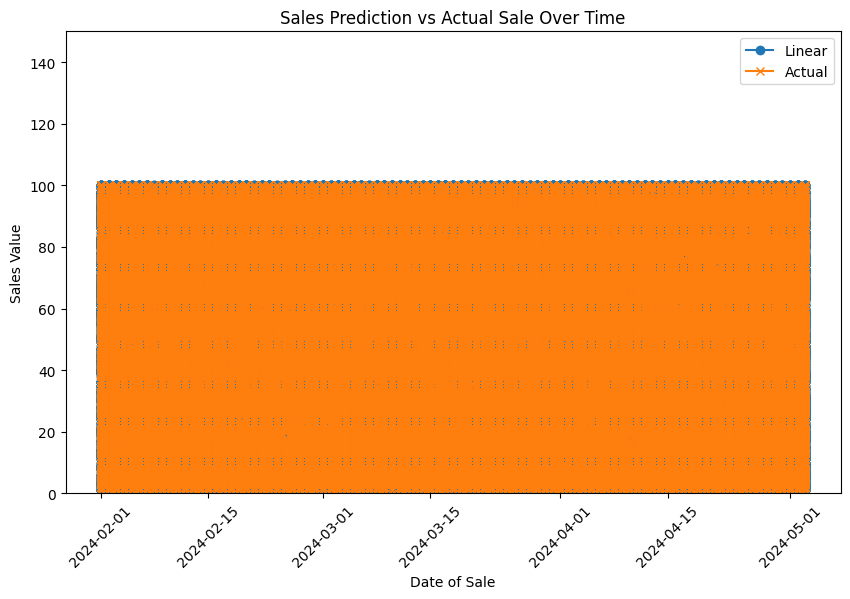

In [144]:
# Create the plot
from datetime import datetime
X_Test['Date of Sale'] = pd.to_datetime(X_Test[['Year', 'Month', 'Day']])
print(X_Test['Date of Sale'].head(10))
print('Predictions:', predictionsLR)
print('Actuals:', Y_Test.head(10))

#X_Test['Date of Sale'] = pd.to_datetime(str(X_Test['Year']) + '-' + str(X_Test['Month']) + '-' + str(X_Test['Day']))
plt.figure(figsize=(10, 6))  # Set the figure size= modelLR.predict(X_Test)
plt.plot(X_Test['Date of Sale'] , predictionsLR, label='Linear', marker='o')  # Plot Sales Prediction
plt.plot(X_Test['Date of Sale'] , Y_Test, label='Actual', marker='x')  # Plot Sales Prediction
# Adding titles and labels
plt.title('Sales Prediction vs Actual Sale Over Time')
plt.xlabel('Date of Sale')
plt.ylabel('Sales Value')
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.ylim(0, 150)

# Adding legend
plt.legend()

# Show the plot
plt.show()
X_Test = X_Test.drop(columns=['Date of Sale'])

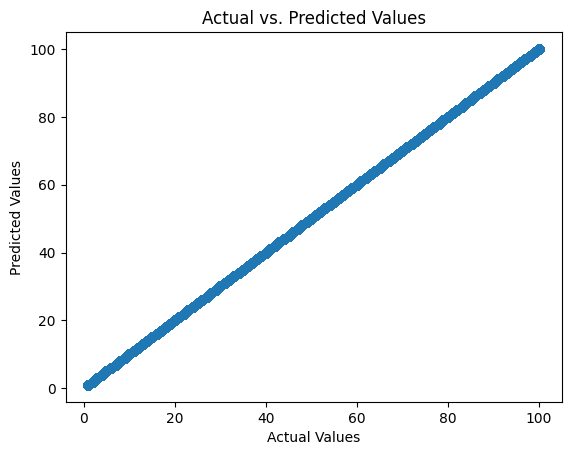

In [145]:
# Plotting actual vs predicted values to visualize how well our model is performing.
plt.scatter(Y_Test, predictionsLR)
plt.xlabel('Actual Values')  # X-axis label
plt.ylabel('Predicted Values')  # Y-axis label
plt.title('Actual vs. Predicted Values')  # Graph title
plt.show()  # Display the plot

#Random Forest

In [146]:
# Creating an instance of the LinearRegression model.
modelRF = RandomForestRegressor()

# Fitting the model to the training data. This is where the model learns the relationship between features and target.
modelRF.fit(X_Train, Y_Train)

RandomForestRegressor()

In [147]:
# Use the trained model to make predictions on the testing set.
predictionsRF = modelRF.predict(X_Test)

# Evaluating the model's performance by comparing actual values (y_test) vs predicted values (predictions).
# MAE is the mean absolute error, MSE is the mean squared error, and RMSE is the square root of MSE.
print('MAE:', mean_absolute_error(Y_Test, predictionsRF))
print('MSE:', mean_squared_error(Y_Test, predictionsRF))
print('RMSE:', np.sqrt(mean_squared_error(Y_Test, predictionsRF)))

MAE: 0.0
MSE: 0.0
RMSE: 0.0


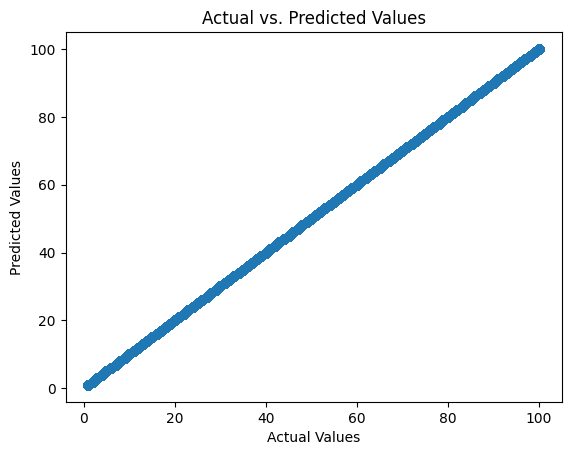

In [149]:
# Plotting actual vs predicted values to visualize how well our model is performing.
plt.scatter(Y_Test, predictionsRF)
plt.xlabel('Actual Values')  # X-axis label
plt.ylabel('Predicted Values')  # Y-axis label
plt.title('Actual vs. Predicted Values')  # Graph title
plt.show()  # Display the plot

##Prophet

In [150]:
pip install pystan


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 83.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 6.8 MB/s eta 0:00:00


In [151]:
pip install fbprophet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 44.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.7 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for fbprophet
  Running setup.py clean for fbprophet
  Created wheel for pymeeus: filename=PyMeeus-0.5.12-py3-none-any.whl size=732001 sha256=17e9de8e7ac212bcb62a0a7c57233aa6fa34a0412355bdf8726dd02a41813d76
  Stored in directory: /root/.cache/pip/wheels/d6/67/78/aa2e8d108639dd23a5e9e72a4fc88bb44f5541894382712f48
Successfully built py

In [152]:
pip install --upgrade numpy pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 39.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 2.2.2 which is incompatible.


In [153]:
pip install prophet


In [154]:
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [155]:
#this has all of the records without the split
dfpt = df
dfpt.rename(columns={'Date of Sale': 'ds', 'Units Sold': 'y'}, inplace=True)
dftrain = dfpt[dfpt['ds'] < split_date]
dftest = dfpt[dfpt['ds'] >= split_date]
modelPT = Prophet(yearly_seasonality=True)
modelPT.fit(dftrain)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_of8eqeo/jek8pxx2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_of8eqeo/1yosrw_z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4226', 'data', 'file=/tmp/tmp_of8eqeo/jek8pxx2.json', 'init=/tmp/tmp_of8eqeo/1yosrw_z.json', 'output', 'file=/tmp/tmp_of8eqeo/prophet_modelbskf8j8_/prophet_model-20240506105120.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:51:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:51:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [156]:
#need to do the split on this to get the future
future = modelPT.make_future_dataframe(periods=len(dftest), freq='D')
forecast = modelPT.predict(future)

In [157]:
#Not sure how valid this is for for Prophet
#print('MAE:', mean_absolute_error(Y_Test, forecast))
#print('MSE:', mean_squared_error(Y_Test, forecast))
#print('RMSE:', np.sqrt(mean_squared_error(Y_Test, forecast)))

In [158]:
# Plotting actual vs predicted values to visualize how well our model is performing.
#plt.scatter(future['ds'], forecast)
#plt.xlabel('Actual Values')  # X-axis label
#plt.ylabel('Predicted Values')  # Y-axis label
#plt.title('Actual vs. Predicted Values')  # Graph title
#plt.show()  # Display the plot

##Gradient Booster

In [159]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor

In [160]:
modelGB = GradientBoostingRegressor(random_state=42)
modelGB.fit(X_Train, Y_Train)

GradientBoostingRegressor(random_state=42)

In [161]:
# Predictions
predGB = modelGB.predict(X_Test)

In [162]:
# Evaluation
mae = mean_absolute_error(Y_Test, predGB)
mse = mean_squared_error(Y_Test, predGB)
r2 = r2_score(Y_Test, predGB)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

Mean Absolute Error: 0.02543612498761985
Mean Squared Error: 0.0015745380069745443
R² Score: 0.999998101716693


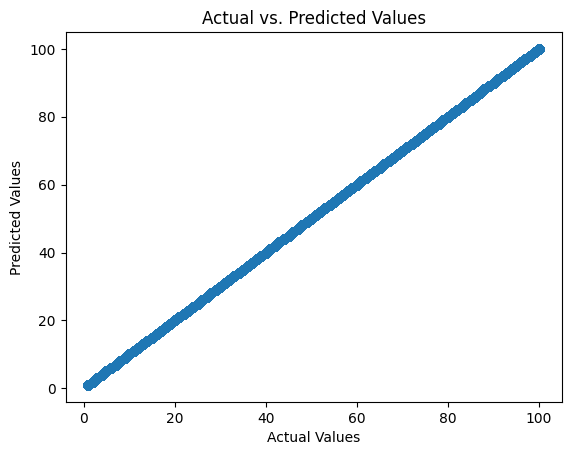

In [163]:
# Plotting actual vs predicted values to visualize how well our model is performing.
plt.scatter(Y_Test, predGB)
plt.xlabel('Actual Values')  # X-axis label
plt.ylabel('Predicted Values')  # Y-axis label
plt.title('Actual vs. Predicted Values')  # Graph title
plt.show()  # Display the plot

#Long Term Short Memory

In [164]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [165]:
# Normalize features
scaler = MinMaxScaler()
target = X_Train['Units Sold'].values.reshape(-1,1)
features_scaled = scaler.fit_transform(X_Train)
target_scaled = scaler.fit_transform(target)

In [166]:
# Data preparation for LSTM
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

In [167]:
time_steps = 1
X, y = create_dataset(features_scaled, target_scaled, time_steps)

In [168]:
# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Problem here is the fact that dates from the forecast period are likely to be in the Training data
#may be able to use the X_Train and X_Test values instead

In [169]:
# LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [170]:
# Fit model
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/30
5599/5599 [==============================] - 30s 5ms/step - loss: 0.0867 - val_loss: 0.0861
Epoch 2/30
5599/5599 [==============================] - 21s 4ms/step - loss: 0.0854 - val_loss: 0.0853
Epoch 3/30
5599/5599 [==============================] - 23s 4ms/step - loss: 0.0854 - val_loss: 0.0852
Epoch 4/30
5599/5599 [==============================] - 20s 4ms/step - loss: 0.0853 - val_loss: 0.0852
Epoch 5/30
5599/5599 [==============================] - 17s 3ms/step - loss: 0.0853 - val_loss: 0.0852
Epoch 6/30
5599/5599 [==============================] - 20s 4ms/step - loss: 0.0852 - val_loss: 0.0851
Epoch 7/30
5599/5599 [==============================] - 16s 3ms/step - loss: 0.0852 - val_loss: 0.0851
Epoch 8/30
5599/5599 [==============================] - 16s 3ms/step - loss: 0.0851 - val_loss: 0.0853
Epoch 9/30
5599/5599 [==============================] - 16s 3ms/step - loss: 0.0851 - val_loss: 0.0851
Epoch 10/30
5599/5599 [==============================] - 17s 3ms/step - l

In [171]:
# Predict and evaluate
predictionLSTM = model.predict(X_test)
mse = mean_squared_error(scaler.inverse_transform(y_test), scaler.inverse_transform(predictionLSTM))
print(f'Mean Squared Error: {mse}')

1400/1400 [==============================] - 2s 2ms/step
Mean Squared Error: 835.018647602245


In [172]:
print(Y_Test)
print()
print(predictionLSTM)

210752     9
35957     55
131439    60
91245     64
285134    14
          ..
113721    99
158541     3
54362     12
205538    31
239730    45
Name: Units Sold, Length: 76044, dtype: int64



210752   2024-02-01
35957    2024-02-01
131439   2024-02-01
91245    2024-02-01
285134   2024-02-01
192537   2024-02-01
219451   2024-02-01
217150   2024-02-01
292747   2024-02-01
274888   2024-02-01
Name: Date of Sale, dtype: datetime64[ns]


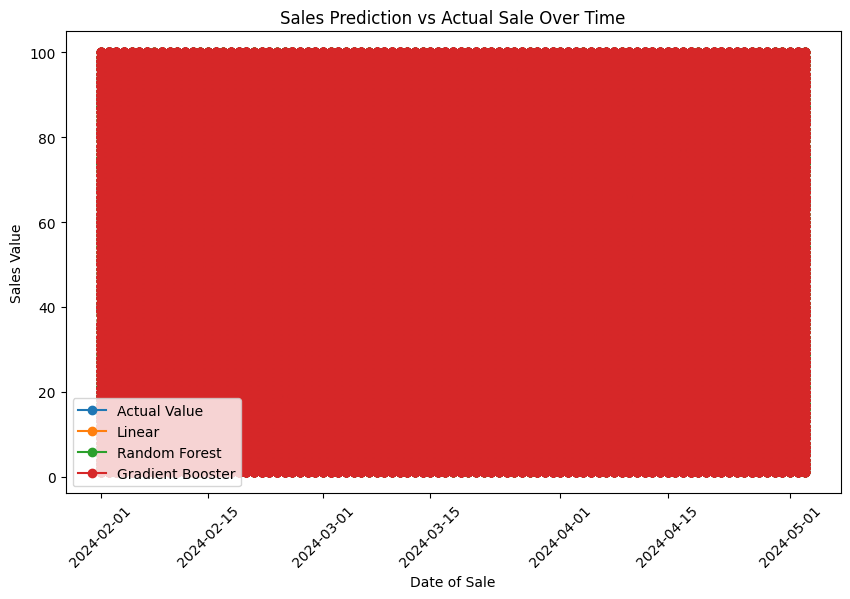

In [174]:
# Create the plot
from datetime import datetime
X_Test['Date of Sale'] = pd.to_datetime(X_Test[['Year', 'Month', 'Day']])
print(X_Test['Date of Sale'].head(10))
#X_Test['Date of Sale'] = pd.to_datetime(str(X_Test['Year']) + '-' + str(X_Test['Month']) + '-' + str(X_Test['Day']))
plt.figure(figsize=(10, 6))  # Set the figure size= modelLR.predict(X_Test)
plt.plot(X_Test['Date of Sale'] , Y_Test, label='Actual Value', marker='o')  # Plot Sales Prediction
plt.plot(X_Test['Date of Sale'] , predictionsLR, label='Linear', marker='o')  # Plot Sales Prediction
plt.plot(X_Test['Date of Sale'] , predictionsRF, label='Random Forest', marker='o')  # Plot Sales Prediction
plt.plot(X_Test['Date of Sale'] , predGB, label='Gradient Booster', marker='o')  # Plot Sales Prediction
#plt.plot(X_Test['Month'] , predictionLSTM, label='Long Term Short Memory', marker='x')  # Plot Sales Prediction

# Adding titles and labels
plt.title('Sales Prediction vs Actual Sale Over Time')
plt.xlabel('Date of Sale')
plt.ylabel('Sales Value')
plt.xticks(rotation=45)  # Rotate date labels for better readability

# Adding legend
plt.legend()

# Show the plot
plt.show()


#Future Steps
For this to be used in the business:
We need to be able to feed in new data and train on that data.  That would be the new Training set.
We then calculate a forecast for the next time period based on the new Training set.